# Explore FFIs and preliminary layout for PSF inference

First let's look at the FFIs, then make a demo of the direction we are going for PSF inference.

We want to instantiate $N_{\mathrm{PSFs}}$ that have a shared point spread function.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from astropy.io import fits
import astropy.visualization
from fast_histogram import histogram1d

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

You can download the K2 campaign Let's download it from the [K2 FFI MAST portal](https://archive.stsci.edu/pub/k2/ffi/).  We'll get both the FFI itself and its `unc` companion file.

In [2]:
#hdu = fits.open('/Volumes/Truro/ffi/ktwo2017079075530-c13_ffi-orig.fits')
hdu = fits.open('../../ffi-motion/data/ktwo2017079075530-c13_ffi-cal.fits')

The FFIs are comprised of many individual modules and channels, etc.  Let's look at one of them.  Module 13 is near "on-axis" of the optical system: it's in the middle of the field of view and should therefore have better-than-average image quality.

In [3]:
mod13p1 = hdu[41]

In [4]:
mod13p1.data.shape

(1070, 1132)

In [5]:
mod13p1.data.min(), mod13p1.data.max()

(-339.89362, 217029.8)

In [6]:
dat = mod13p1.data + 500
logdat = np.log10(dat)

In [7]:
minmax = astropy.visualization.MinMaxInterval()

In [8]:
vmin, vmax = minmax.get_limits(logdat)
vmin, vmax

(2.2044086, 5.3375187)

In [9]:
x = np.linspace(vmin, vmax, 200)
y = histogram1d(logdat.reshape(-1), bins=200, range=(vmin, vmax))

Let's improve the *screen stretch* for readability.

In [10]:
good_interval = astropy.visualization.AsymmetricPercentileInterval(10, 95.0)
vmin, vmax = good_interval.get_limits(logdat)

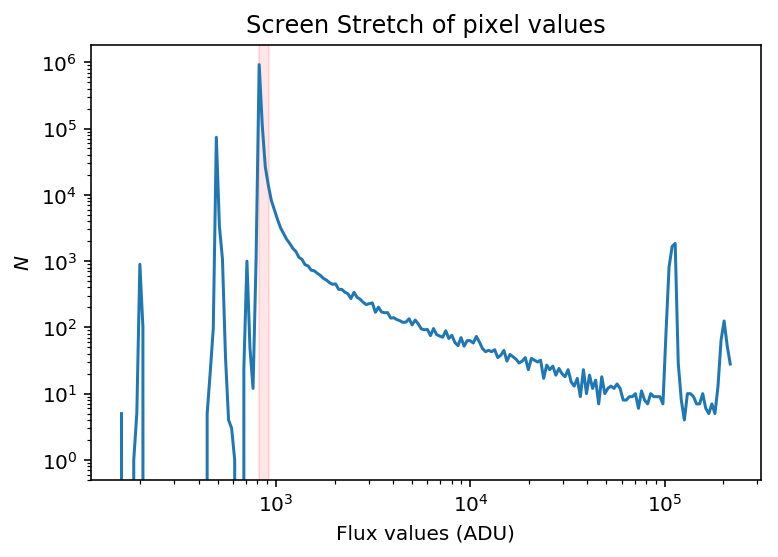

In [11]:
plt.plot(10**x, y)
plt.axvspan(10**vmin, 10**vmax, alpha=0.1, color='r')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Flux values (ADU)')
plt.ylabel('$N$')
plt.title('Screen Stretch of pixel values');

In [12]:
norm = astropy.visualization.ImageNormalize(vmin=10**vmin, vmax=10**vmax)

In [13]:
lx, ly = dat[450:-450, 450:-450].shape
lx, ly

(170, 232)

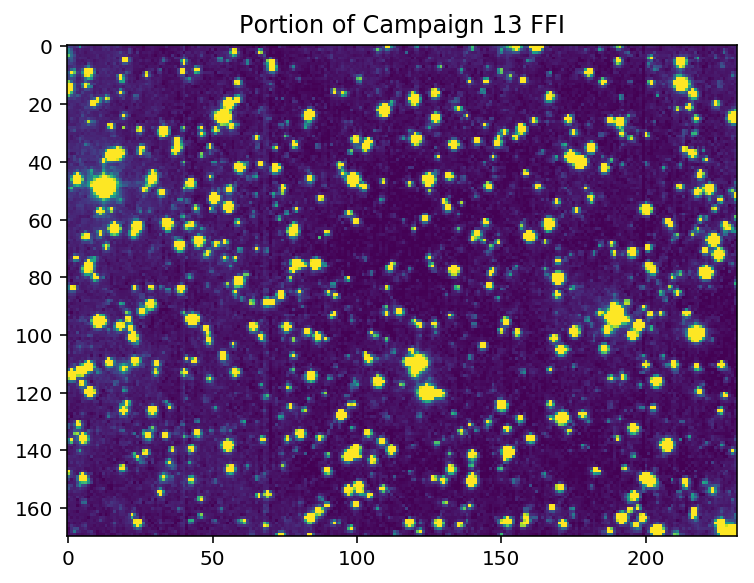

In [14]:
w, h = plt.figaspect(ly/lx)
scl=1.5
plt.figure(figsize=(scl*w,scl*h))
plt.imshow(dat[450:-450, 450:-450], norm=norm)
plt.title('Portion of Campaign 13 FFI');

Neat! Stars and some artifacts.

## Make synthetic data

It will be easier to debug things when we have fake data with known properties.

In [15]:
synth = dat[450:-450, 450:-450]

In [16]:
10**vmin, 10**vmax

(820.79172487461653, 916.90475700185948)

In [17]:
bkg_mean = 850.0
rd_noise = 4.0
synth = synth*0.0 + bkg_mean + np.random.randn(lx, ly) * rd_noise

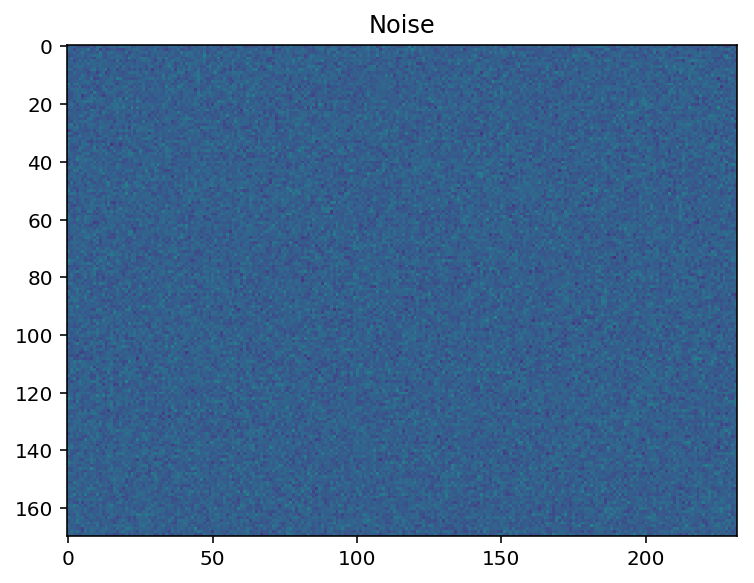

In [18]:
w, h = plt.figaspect(ly/lx)
scl=1.5
plt.figure(figsize=(scl*w,scl*h))
plt.imshow(synth, norm=norm)
plt.title('Noise');

Let's make some fake PSFs.

In [19]:
from scipy import stats

In [20]:
mean_vec = np.array([100,150])
cov_arr = np.array([[2.5,1.3], [-1.3, 2.0]])
fake_psf = stats.multivariate_normal(mean_vec, cov_arr)

In [21]:
def gen_fake_psfs(mean_vec=[100,150], cov_arr=[[2.2,0.9], [-0.9, 2.0]],
                 lx=170, ly=232):
    '''Generate one fake psf'''
    fake_psf = stats.multivariate_normal(mean_vec, cov_arr)
    xx, yy = np.mgrid[0:lx:1, 0:ly:1]
    pos = np.stack([xx, yy], axis=2)
    gen_data = fake_psf.pdf(pos)
    return (xx, yy, pos, gen_data)

In [22]:
xcrange=[0, 170]
ycrange=[0,232]
xc, yc = np.random.uniform(low=[xcrange[0], ycrange[0]], 
                           high=[xcrange[1], ycrange[1]], size=2)

In [23]:
xc, yc

(165.7792876634411, 145.27762474308733)

In [24]:
def gen_many_default_psfs(xcrange=[0, 170], ycrange=[0,232], n_psfs=5):
    '''Generate many default PSFs combined in a single image'''
    cen_out = []
    for i in range(n_psfs):
        xc, yc = np.random.uniform(low=[xcrange[0], ycrange[0]], 
                               high=[xcrange[1], ycrange[1]], size=2)
        cen_out += [[xc, yc]]
        if i ==0:
            _, _, _, psf = gen_fake_psfs(mean_vec=[xc, yc])
        else:
            _, _, _, psfi = gen_fake_psfs(mean_vec=[xc, yc])
            psf = psf + psfi
    return cen_out, psf

In [25]:
xx0, yy0, pos0, _ = gen_fake_psfs()

In [26]:
centers, tot_psf = gen_many_default_psfs(n_psfs=5)

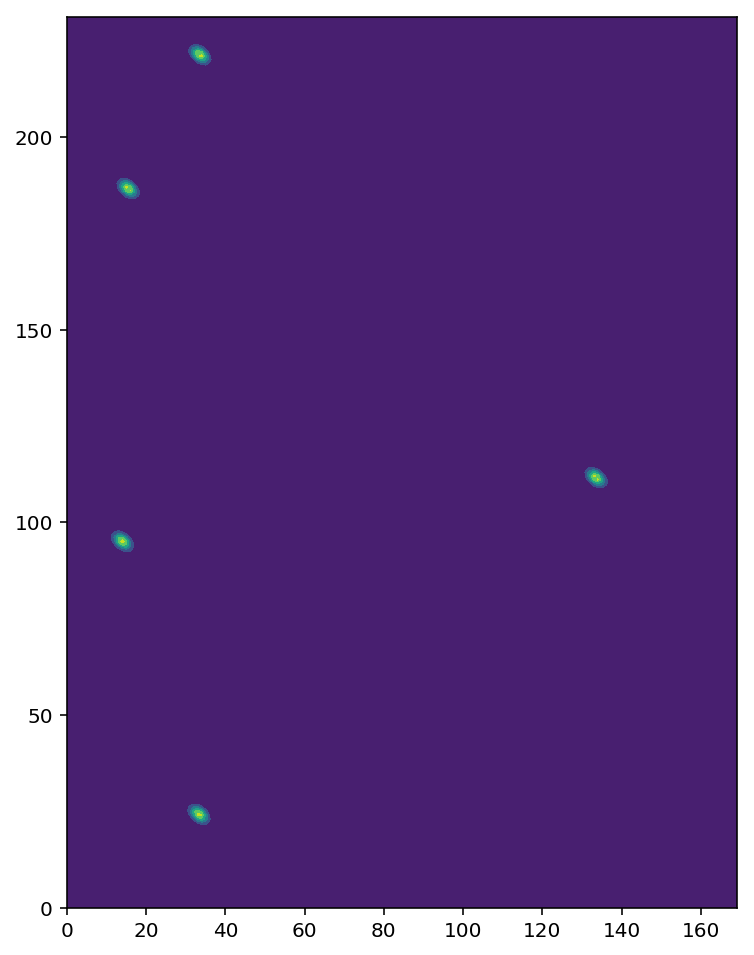

In [27]:
w, h = plt.figaspect(ly/lx)
scl=1.5
plt.figure(figsize=(scl*w,scl*h))
plt.contourf(xx0, yy0, tot_psf)

Cool!  Fake data!

Let's make the delta-function image.

In [28]:
delta_funcs = tot_psf*0.0
centers = np.array(centers)
n_psfs, _ = centers.shape

for cxy in centers:
    delta_funcs[int(cxy[0]), int(cxy[1])] = 1

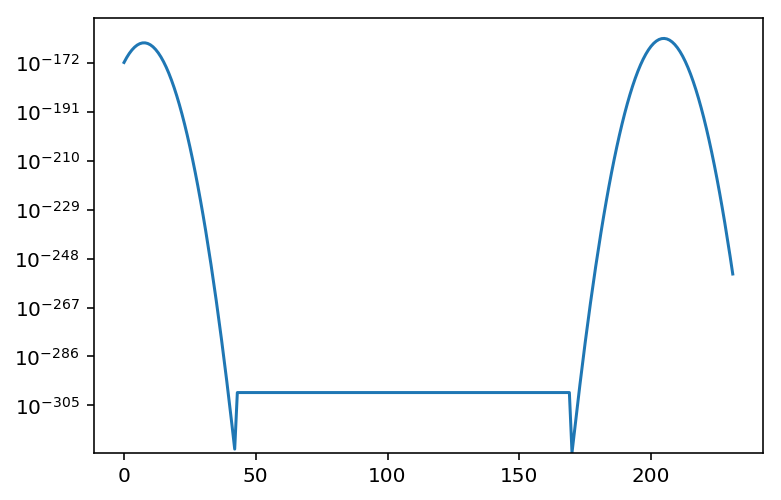

In [29]:
plt.plot(tot_psf[74, :])
plt.yscale('log')

In [30]:
oned = tot_psf[74, :]

## Try the convolution route

In [31]:
from scipy import signal

In [32]:
_,_,_, kernel = gen_fake_psfs(mean_vec=[20,20], cov_arr=[[2.2,0.9], [-0.9, 2.0]],
                 lx=40, ly=40)

In [33]:
convolved_deltas = signal.convolve2d(delta_funcs, kernel, mode='same', )

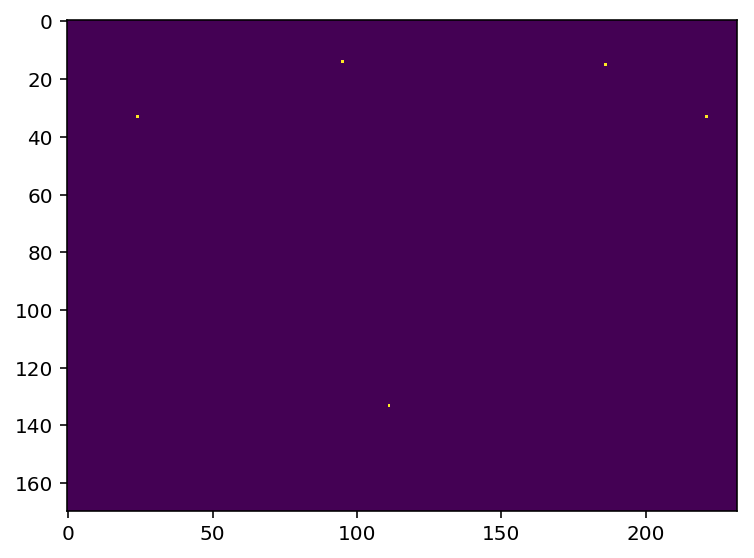

In [34]:
w, h = plt.figaspect(ly/lx)
scl=1.5
plt.figure(figsize=(scl*w,scl*h))
plt.imshow(delta_funcs)

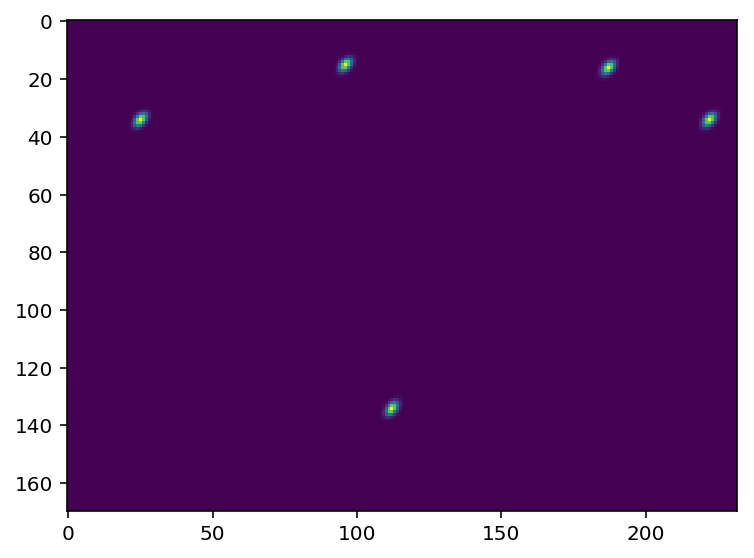

In [35]:
w, h = plt.figaspect(ly/lx)
scl=1.5
plt.figure(figsize=(scl*w,scl*h))
plt.imshow(convolved_deltas)

## Try the FFT multiplication route

In [36]:
ss = pos0

In [37]:
sigma = 2.3
taper = np.exp(-2 * (np.pi ** 2) * (sigma ** 2) * (ss ** 2))

In [38]:
#FF_tap = FF * taper

```python
ss = np.fft.rfftfreq(self.pca.npix, d=self.emulator.dv)

from scipy import fftpack

fftpack.

FF = np.fft.rfft(oned)

FF = np.fft.fft2(delta_funcs)

ssx = np.fft.fftfreq(170, d=1)

FF.shape

np.median

ssx.shape
```

FFT is a dead end, easier to just use the convolution directly.